In [4]:
import torch
import torchvision

In [5]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Resize
import matplotlib.pyplot as plt
from torchvision import transforms


In [6]:
read_train=torchvision.datasets.ImageFolder(root="/kaggle/input/mrl-eye-dataset/data/train/", transform=transforms.Compose([Resize(60),ToTensor()]))
read_test=torchvision.datasets.ImageFolder(root="/kaggle/input/mrl-eye-dataset/data/test/", transform=transforms.Compose([Resize(60),ToTensor()]))

In [7]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [8]:
len(read_train)

81675

In [9]:
for x, y in read_train:
    print(x.shape,y)
    break

torch.Size([3, 60, 60]) 0


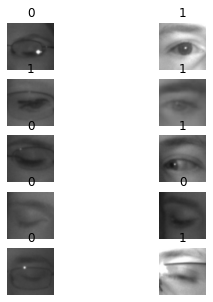

In [10]:
figure=plt.figure(figsize=(5,5))
columns, rows=2,5
for i in range(1,(columns*rows)+1):
    idx=torch.randint(len(read_train),size=(1,)).item()
    image,label=read_train[idx]
    image=image.permute(1,2,0)
    figure.add_subplot(rows,columns,i);
    plt.title(label)
    plt.axis("off")
    plt.imshow(image)
plt.show()

In [11]:
train=DataLoader(dataset=read_train,batch_size=64,shuffle=True)
test=DataLoader(dataset=read_test,batch_size=64,shuffle=True)

In [12]:
device='cpu'
if torch.cuda.is_available():
    device='cuda'

In [13]:
device

'cuda'

In [14]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.layer1=nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(2,2))
        self.a1=nn.ReLU()
        self.layer2=nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(2,2))
        self.a2=nn.ReLU()
        self.layer3=nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1,1))
        self.a3=nn.ReLU()
        self.layer4=nn.Flatten()
        self.layer5=nn.Linear(64*58*58,2)
    def forward(self, input):
        out1=self.layer1(input)
        ao1=self.a1(out1)
        out2=self.layer2(ao1)
        ao2=self.a2(out2)
        out3=self.layer3(ao2)
        ao3=self.a3(out3)
        out4=self.layer4(ao3)
        out5=self.layer5(out4)
        return out5

In [15]:
model=NeuralNetwork().to(device)

In [16]:
model

NeuralNetwork(
  (layer1): Conv2d(3, 16, kernel_size=(2, 2), stride=(1, 1))
  (a1): ReLU()
  (layer2): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1))
  (a2): ReLU()
  (layer3): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
  (a3): ReLU()
  (layer4): Flatten(start_dim=1, end_dim=-1)
  (layer5): Linear(in_features=215296, out_features=2, bias=True)
)

In [17]:
loss=nn.CrossEntropyLoss()

In [18]:
opt=torch.optim.Adam(params=model.parameters(), lr=0.001)

In [19]:
batch=64

In [20]:
def train_loop(train,model,loss,opt):
    n=len(train.dataset)
    for batch, (x,y) in enumerate(train):
        x=x.to(device)
        y=y.to(device)
        pred=model(x)
        l=loss(pred,y)
        opt.zero_grad()
        l.backward()
        opt.step()

        if batch%200==0:
            l, curr=l.item(),batch*len(x)
            print(f"loss: {l:>7f}  [{curr:>5d}/{n:>5d}]")

def test_loop(test,model,loss_fn):
    n=len(test.dataset)
    nb=len(test)
    l,c=0,0

    with torch.no_grad():
        for x,y in test:
            x=x.to(device)
            y=y.to(device)
            pred=model(x)
            l+=loss(pred,y).item()
            c+=(pred.argmax(axis=1)==y).type(torch.float).sum().item()

    l/=nb
    c/=n

    print(f"Test Error: \n Accuracy: {(100*c):>0.1f}%, Avg loss: {l:>8f} \n")

In [21]:
epochs=10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train, model, loss, opt)
    test_loop(test, model, loss)
print("Done!")

Epoch 1
-------------------------------
loss: 0.693459  [    0/81675]
loss: 0.152311  [12800/81675]
loss: 0.134539  [25600/81675]
loss: 0.280868  [38400/81675]
loss: 0.135615  [51200/81675]
loss: 0.204317  [64000/81675]
loss: 0.185574  [76800/81675]
Test Error: 
 Accuracy: 83.4%, Avg loss: 0.470066 

Epoch 2
-------------------------------
loss: 0.316238  [    0/81675]
loss: 0.171581  [12800/81675]
loss: 0.129388  [25600/81675]
loss: 0.052908  [38400/81675]
loss: 0.148260  [51200/81675]
loss: 0.118804  [64000/81675]
loss: 0.255731  [76800/81675]
Test Error: 
 Accuracy: 89.8%, Avg loss: 0.291596 

Epoch 3
-------------------------------
loss: 0.071263  [    0/81675]
loss: 0.100369  [12800/81675]
loss: 0.101284  [25600/81675]
loss: 0.136775  [38400/81675]
loss: 0.089328  [51200/81675]
loss: 0.099701  [64000/81675]
loss: 0.064690  [76800/81675]
Test Error: 
 Accuracy: 92.8%, Avg loss: 0.192038 

Epoch 4
-------------------------------
loss: 0.138307  [    0/81675]
loss: 0.154024  [12800/8

In [22]:
torch.save(model.state_dict(), 'model.pytorch')